In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from sklearn import preprocessing
from scipy import stats
import datetime as dt
from sklearn import model_selection
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# 8.1 DATA PREPARATION

## (a) Load and Prepare Data

In [4]:
ACC = pd.read_csv("acceleration.txt", sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv("heartrate.txt", sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv("labeled_sleep.txt", sep = ' ',names=['timedelta', 'sleep'])



In [5]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
print("ACC Start: %f End: %f " % (ACC_min_date,ACC_max_date))
print("HeartR Start: %f End: %f " % (HeartR_min_date,HeartR_max_date))
print("SleepL Start: %f End: %f " % (SleepL_min_date,SleepL_max_date))


ACC Start: -124489.161050 End: 17643.046417 
HeartR Start: -556410.360660 End: 16980.472290 
SleepL Start: 0.000000 End: 16980.000000 


In [6]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_new = ACC[(ACC["timedelta"]> ACC_min_date) & (ACC["timedelta"] < ACC_max_date) & (ACC["timedelta"]> HeartR_min_date) & (ACC["timedelta"] < HeartR_max_date) &(ACC["timedelta"]> SleepL_min_date) & (ACC["timedelta"] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR["timedelta"]> ACC_min_date) & (HeartR["timedelta"] < ACC_max_date) & (HeartR["timedelta"]> HeartR_min_date) & (HeartR["timedelta"] < HeartR_max_date) &(HeartR["timedelta"]> SleepL_min_date) & (HeartR["timedelta"] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL["timedelta"]> ACC_min_date) & (SleepL["timedelta"] < ACC_max_date) & (SleepL["timedelta"]> HeartR_min_date) & (SleepL["timedelta"] < HeartR_max_date) &(SleepL["timedelta"]> SleepL_min_date) & (SleepL["timedelta"] < SleepL_max_date)]
ACC_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


## (b) Load and Prepare Data (ACC)

In [7]:
# Convert to datetime and round to second using an ACC as the value as the *** as units.
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 's').round('1s'))

 # Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()
ACC_new2

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_17920\2589896904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 's').round('1s'))


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [8]:
# 1 2 3 -> 1-1 2-1 3-1  -> 0 1 2 

# ACC_new2['timedelta'] = ACC_new2['timedelta'] - ACC_new2['timedelta'].min() 
ACC_new2

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


# (c) Load and Prepare Data (Heart rate)

In [9]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],'s').round('1s'))
# HeartR_new['timedelta'] = HeartR_new['timedelta'] - HeartR_new['timedelta'].min() 
HeartR_new

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_17920\1135719712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],'s').round('1s'))


,timedelta,heartrate
1576,0 days 00:00:08,97
1577,0 days 00:00:13,95
1578,0 days 00:00:18,96
1579,0 days 00:00:19,95
1580,0 days 00:00:24,95
...,...,...
4872,0 days 04:42:34,73
4873,0 days 04:42:39,72
4874,0 days 04:42:44,74
4875,0 days 04:42:50,75


In [10]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [11]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],'s').round('1s'))
# SleepL_new['timedelta'] = SleepL_new['timedelta'] - SleepL_new['timedelta'].min() 

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_17920\512641816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],'s').round('1s'))


In [12]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


# (e) Merge Data and Standardized data

In [13]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on ='timedelta')
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,NaN,NaN
1,0 days 00:00:01,-0.240757,0.873826,0.415446,NaN,NaN
2,0 days 00:00:02,-0.244620,0.883943,0.387026,NaN,NaN
3,0 days 00:00:03,-0.248036,0.902427,0.347812,NaN,NaN
4,0 days 00:00:04,-0.241778,0.912946,0.321502,NaN,NaN
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [14]:
# Fill NA
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df['sleep'] = df['sleep'].fillna(0)

df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,82.0,0.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,82.0,0.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,82.0,0.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,82.0,0.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [15]:
df.drop(['timedelta'],axis=1)

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,82.0,0.0
1,-0.240757,0.873826,0.415446,82.0,0.0
2,-0.244620,0.883943,0.387026,82.0,0.0
3,-0.248036,0.902427,0.347812,82.0,0.0
4,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [16]:
# Standardized data
scaler = preprocessing.StandardScaler()
feature_columns = df[['accX', 'accY', 'accZ', 'heartrate']]
label_columns = df[['sleep']]
df_feature = pd.DataFrame(scaler.fit_transform(feature_columns.values),index = feature_columns.index,columns=feature_columns.columns)
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.143539
1,-0.581456,2.995094,0.757746,0.143539
2,-0.591075,3.024668,0.722696,0.143539
3,-0.599581,3.078699,0.674335,0.143539
4,-0.583998,3.109450,0.641889,0.143539
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630455
16977,-1.082531,-1.095348,1.137542,-0.630455
16978,-1.081511,-1.094296,1.138273,-0.630455
16979,-1.083260,-1.096440,1.137363,-0.630455


<AxesSubplot:>

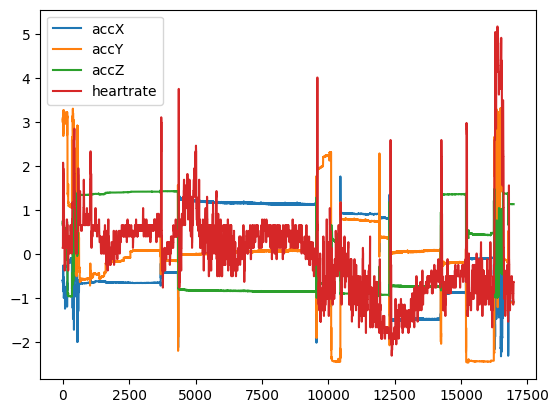

In [17]:
df_feature.plot()


In [18]:
df_label =label_columns

<AxesSubplot:>

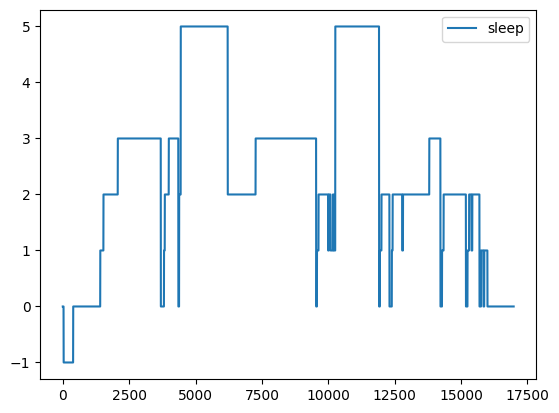

In [19]:
df_label.plot()

# SVM


In [20]:
# Train / Test Preparation
dataX = df_feature.copy()
dataY = df_label.copy()
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(dataX, dataY, test_size = 0.3, random_state = 0)


In [21]:
c_val = 100 
gmm =0.1
d = 2

In [22]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [23]:

svc_rbf.fit(X_train, Y_train)
svc_rbf_pred = svc_rbf.predict(X_test)

c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
svc_poly = svc_poly.fit(X_train, Y_train)
svc_poly_pred = svc_poly.predict(X_test)

c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## (b) SVM Prediction Report

In [25]:
# Model Confusion Matrix of SVC_rbf, SVC_poly
print("confusion_matrix_rbf :\n",confusion_matrix(Y_test,svc_rbf_pred))
print("confusion_matrix_poly :\n",confusion_matrix(Y_test,svc_poly_pred))



confusion_matrix_rbf :
 [[ 107    9    0    0    0    0]
 [   1  544    6  149   25    7]
 [   0   68   54  127    1   10]
 [   0   46    8 1391   92   48]
 [   0    0    0   69 1311    1]
 [   6    2    0  184    0  829]]
confusion_matrix_poly :
 [[ 107    9    0    0    0    0]
 [   6  503  126   70   22    5]
 [   3   15  117  108    5   12]
 [   0   17  119 1157  209   83]
 [   0   13    0  143 1224    1]
 [   0    1    3  159    5  853]]


In [26]:
print("Classification Report_rbf :\n",classification_report(Y_test,svc_rbf_pred))
print("Classification Report_poly :\n",classification_report(Y_test,svc_poly_pred))

Classification Report_rbf :
               precision    recall  f1-score   support

        -1.0       0.94      0.92      0.93       116
         0.0       0.81      0.74      0.78       732
         1.0       0.79      0.21      0.33       260
         2.0       0.72      0.88      0.79      1585
         3.0       0.92      0.95      0.93      1381
         5.0       0.93      0.81      0.87      1021

    accuracy                           0.83      5095
   macro avg       0.85      0.75      0.77      5095
weighted avg       0.84      0.83      0.82      5095

Classification Report_poly :
               precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92       116
         0.0       0.90      0.69      0.78       732
         1.0       0.32      0.45      0.37       260
         2.0       0.71      0.73      0.72      1585
         3.0       0.84      0.89      0.86      1381
         5.0       0.89      0.84      0.86      1021

    accuracy      

# 8.3 HYPERPARAMETER TUNING (GRIDSEARCHCV())

In [27]:
#Create Model Parameter Dictionary for SVC
# C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
# Gamma_list = [0.01, 0.1, 1.0, 10]
# d_list = [2, 3]

In [28]:
param_grid = {'C':  [0.1, 1.0, 10.0, 100.0, 200.0], 'gamma': [0.01, 0.1, 1.0],'degree':[2,3],'kernel': ['rbf','poly']} 
# param_grid = {'C':  [0.1, 1.0, 10.0, 100.0, 200.0, 500.0], 'gamma': [0.01, 0.1, 1.0, 10],'degree':[2,3],'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid,scoring = 'accuracy', cv = 2, verbose = 3,n_jobs=-1)  
# fitting the model for grid search
grid_result = grid.fit(X_train, Y_train)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# Show Best Parameters for both models
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)



Best params:  {'C': 200.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
Best score:  0.9024903247518088


Fitting 2 folds for each of 30 candidates, totalling 60 fits


c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params:  {'C': 200.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
Best score:  0.8504963822985024
0.295726 (0.000084) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.484940 (0.007908) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.692832 (0.000757) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.295726 (0.000084) with: {'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.571849 (0.006142) with: {'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
0.769729 (0.000421) with: {'C': 0.1, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
0.384402 (0.003449) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.652448 (0.002608) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.745583 (0.003534) with: {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.305570 (0.000168) with: {'C': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
0.664059 (0.000252) with: {'C': 1.0, 'degree': 3, 'gamma': 0.1, 'kernel'

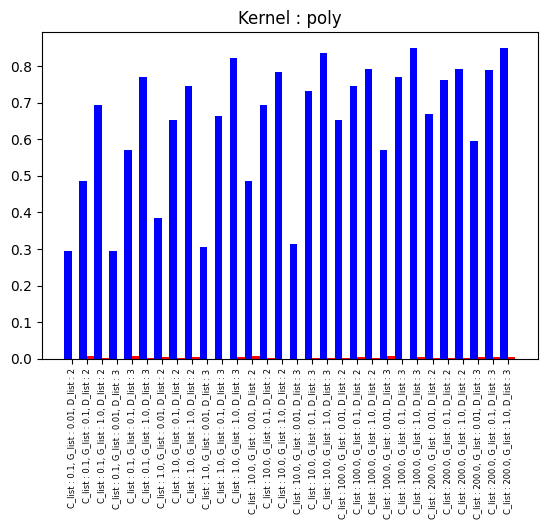

In [30]:
# Create Model Parameter Dictionary for SVC
kernel = ['poly'] #['rbf','poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0]
Gamma_list = [0.01, 0.1, 1.0]
d_list = [2, 3]
params = dict(kernel = kernel,C = C_list,gamma = Gamma_list,degree = d_list)
# Perform GridsearchCV() for each classification model
grid = GridSearchCV( estimator=  SVC(), n_jobs = -1, verbose = 10, scoring = 'accuracy', cv = 2, param_grid = params)
grid_result = grid.fit(X_train, Y_train)
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
mean = grid_result.cv_results_['mean_test_score']
std = grid_result.cv_results_['std_test_score']
param = grid_result.cv_results_['params']

bar_mean = []
bar_std = []
bar_param = []
for mean, stdev, param in zip(mean, std, param):
    print("%f (%f) with: %r" % (mean, stdev, param))
    bar_mean.append(mean)
    bar_std.append(stdev)
    bar_param.append("C_list : "+ str(param['C']) + ", G_list : " + str(param['gamma']) + ", D_list : " + str(param['degree']))

x = np.arange(len(bar_mean))
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Kernel : poly')
rect1 = plt.bar(x-w/2,bar_mean,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_std,w,color = 'r')
ax.set_xticks(x, labels= bar_param,fontsize=6,rotation = 90)
plt.subplots_adjust(bottom=0.20)
plt.show()

Fitting 2 folds for each of 30 candidates, totalling 60 fits


c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params:  {'C': 200.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
Best score:  0.9024903247518088
0.506815 (0.000000) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.643951 (0.012956) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.729598 (0.005721) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.506815 (0.000000) with: {'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
0.643951 (0.012956) with: {'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
0.729598 (0.005721) with: {'C': 0.1, 'degree': 3, 'gamma': 1.0, 'kernel': 'rbf'}
0.557883 (0.004459) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.724297 (0.004122) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.795894 (0.003365) with: {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.557883 (0.004459) with: {'C': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
0.724297 (0.004122) with: {'C': 1.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
0.

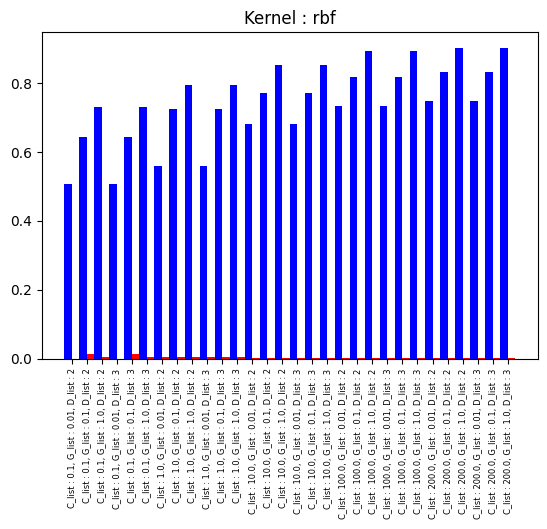

In [31]:
kernel = ['rbf']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0]
Gamma_list = [0.01, 0.1, 1.0]
d_list = [2, 3]
params = dict(kernel = kernel,C = C_list,gamma = Gamma_list,degree = d_list)
# Perform GridsearchCV() for each classification model
grid = GridSearchCV( estimator=  SVC(), n_jobs = -1, verbose = 10, scoring = 'accuracy', cv = 2, param_grid = params)
grid_result = grid.fit(X_train, Y_train)
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
mean = grid_result.cv_results_['mean_test_score']
std = grid_result.cv_results_['std_test_score']
param = grid_result.cv_results_['params']

bar_mean = []
bar_std = []
bar_param = []
for mean, stdev, param in zip(mean, std, param):
    print("%f (%f) with: %r" % (mean, stdev, param))
    bar_mean.append(mean)
    bar_std.append(stdev)
    bar_param.append("C_list : "+ str(param['C']) + ", G_list : " + str(param['gamma']) + ", D_list : " + str(param['degree']))

x = np.arange(len(bar_mean))
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Kernel : rbf')
rect1 = plt.bar(x-w/2,bar_mean,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_std,w,color = 'r')
ax.set_xticks(x, labels= bar_param,fontsize=6,rotation = 90)
plt.subplots_adjust(bottom=0.20)
plt.show()